In [2]:
options(warn = -1)
pacotes <- c("tidyquant", "timetk", "dplyr", "ggplot2", "tidyr", "PortfolioAnalytics",
             "corrplot")
for(i in pacotes){
  library(i, character.only = T)
}

Loading required package: lubridate


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: PerformanceAnalytics

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend


Loading required package: quantmod

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.

== Need to Learn tidyquant? ====================================================
Business Science offers a 1-hour course - Learning Lab #9: Performance Analysis & Portfolio Optimization with tidyquant!
</> Learn more at: https://university.business-science.io/p/learning-

In [3]:
#Coletando os dados
acoes <- c("B3SA3.SA", "ABEV3.SA", "PETR4.SA", "EGIE3.SA",
          "ITUB4.SA", "MGLU3.SA", "UGPA3.SA", "COGN3.SA")
s <- tq_get(acoes, from = "2010-01-01")

In [4]:
#Mudando os dados
month_retun <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "monthly")
daily_retunr <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "daily")
retornos_m <- month_retun %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Mensal_Médio = mean(monthly.returns),
            Desvio_Mensal = sd(monthly.returns)) %>%
  gather(Retorno_Mensal_Médio, Desvio_Mensal, key = statistic, value = value)
retornos <- daily_retunr %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Diário = mean(daily.returns),
            Desvio_Padrão = sd(daily.returns)) %>%
  gather(Retorno_Diário, Desvio_Padrão, key = statistic, value = value)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)



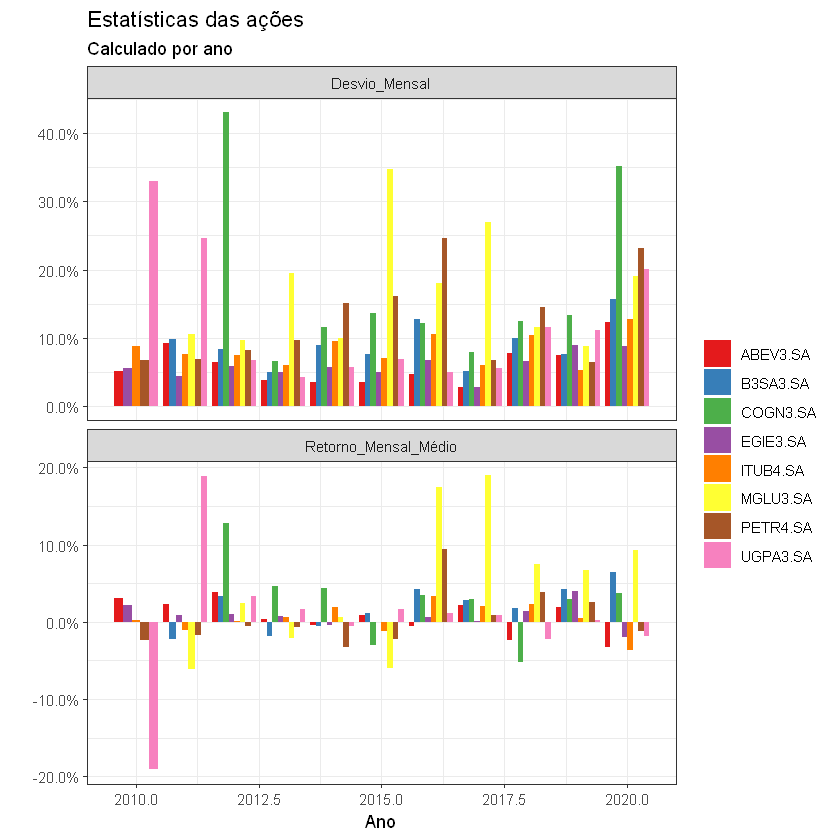

In [5]:
#Gráficos
retornos_m %>%
  ggplot(aes(year,value))+
  geom_col(aes(fill = symbol), position = "dodge")+
  scale_y_continuous(labels = scales::percent)+
  theme_bw()+
  scale_fill_brewer(palette = "Set1",
                    name = "")+
  facet_wrap(~statistic, scales = "free_y", nrow = 2)+
  labs(x = "Ano", y = "", title = "Estatísticas das ações",
      subtitle = "Calculado por ano")

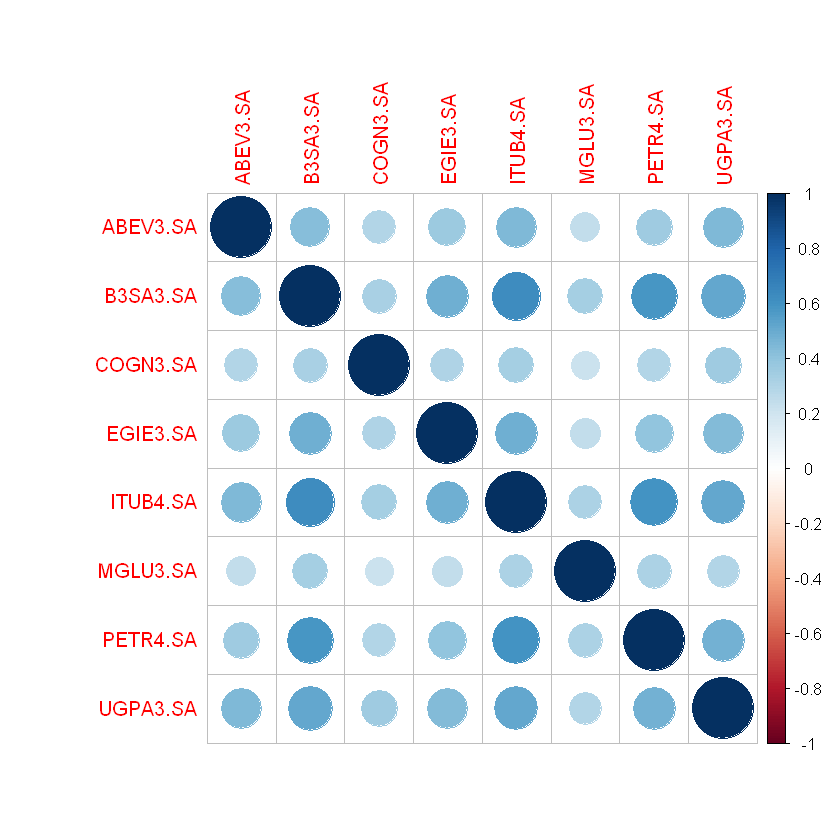

In [6]:
correlacao <- daily_retunr %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit()
correlacao <- cor(correlacao[,2:ncol(correlacao)])
corrplot(correlacao)

In [7]:
correlacao

,ABEV3.SA,B3SA3.SA,COGN3.SA,EGIE3.SA,ITUB4.SA,MGLU3.SA,PETR4.SA,UGPA3.SA
ABEV3.SA,1.0000000,0.4225293,0.2970995,0.3676373,0.4422741,0.2423982,0.3561160,0.4433479
B3SA3.SA,0.4225293,1.0000000,0.3205233,0.4812988,0.6269930,0.3348221,0.5805526,0.5194488
COGN3.SA,0.2970995,0.3205233,1.0000000,0.3090205,0.3345529,0.2121295,0.2971811,0.3501537
EGIE3.SA,0.3676373,0.4812988,0.3090205,1.0000000,0.4815717,0.2470717,0.3973185,0.4398830
ITUB4.SA,0.4422741,0.6269930,0.3345529,0.4815717,1.0000000,0.3103516,0.5964217,0.5105894
MGLU3.SA,0.2423982,0.3348221,0.2121295,0.2470717,0.3103516,1.0000000,0.3143326,0.2918511
PETR4.SA,0.3561160,0.5805526,0.2971811,0.3973185,0.5964217,0.3143326,1.0000000,0.4741423
UGPA3.SA,0.4433479,0.5194488,0.3501537,0.4398830,0.5105894,0.2918511,0.4741423,1.0000000


[1] 0.2121295

In [10]:
acoes <- c("PETR4.SA", "VALE3.SA")
data_inicio <- as.Date("2001-01-01")
a <- tq_get(acoes, from = data_inicio)
d <- a %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "daily")
estat <- d %>%
  mutate(month = format(date, "%Y-%m-01")) %>%
  group_by(month, symbol) %>%
  summarise(Retorno = prod(1+daily.returns)-1, Desvio = sd(daily.returns))

`summarise()` regrouping output by 'month' (override with `.groups` argument)



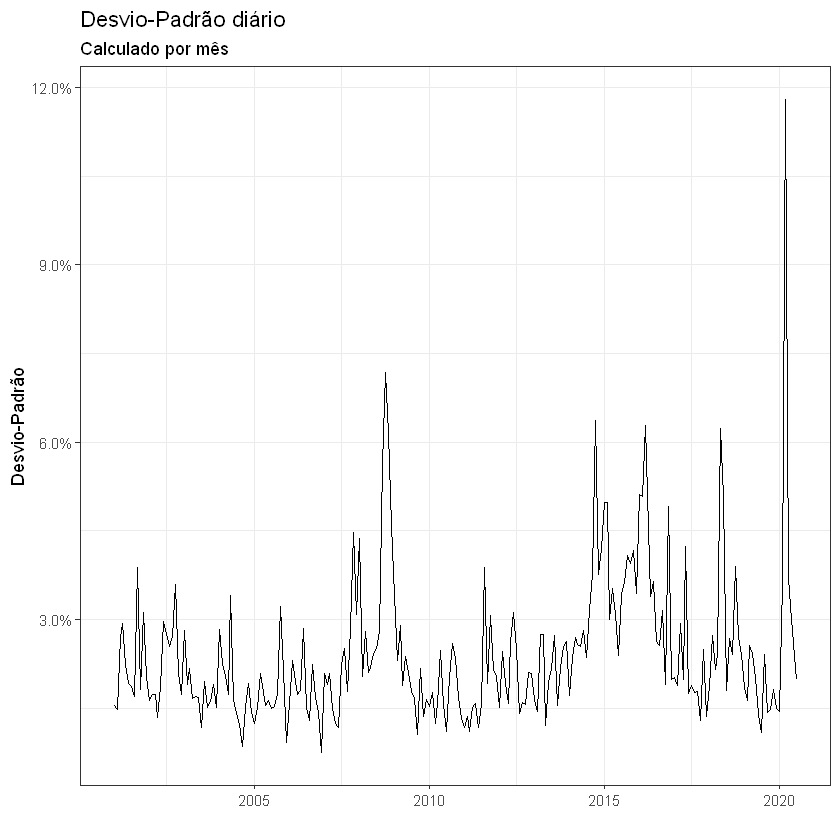

In [18]:
es <- estat %>%
  gather(key = "Estatística",value = "value", -c(symbol, month))
es %>%
  filter(Estatística == "Desvio" & symbol == "PETR4.SA") %>%
  ggplot(aes(x = seq(as.Date("2001-01-01"), as.Date("2020-07-01"), "1 month"), y = value))+
  geom_line()+
  labs(x = "", y = "Desvio-Padrão", title = "Desvio-Padrão diário",
       subtitle = "Calculado por mês")+
  scale_y_continuous(labels = scales::percent)+
  theme_bw()